In [1]:
pip install torchinfo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import time
import random
from random import sample

from torchinfo import summary
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torchtext
from torchtext import data, datasets
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

sns.set(palette="Set2")
sns.set_style("whitegrid")

# Загрузим необходимые датасеты nltk


print(f"torchtext version: {torchtext.version}")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


torchtext version: <module 'torchtext.version' from '/usr/local/lib/python3.10/dist-packages/torchtext/version.py'>


In [3]:
import re
import codecs
from collections import Counter

def preprocess_text(text):
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub('[a-zA-z]', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = re.sub(' +', ' ', text)

    return text.strip()


def prepare_for_w2v(filename_from, filename_to, lang):
    raw_text = codecs.open(filename_from, "r").read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text, lang):
            print(preprocess_text(sentence.lower()), file=f)

def remove_rare(tokens, min_entry = 10):
  counts = Counter(tokens)
  filtred_words = set([token for token, count in counts.items() if count > min_entry])
  tokens = [token for token in tokens if token in filtred_words]
  return tokens

def prepare_txt(input_filename, lang):
  text = preprocess_text(codecs.open(input_filename, 'r').read())
  tokens = word_tokenize(text)

  stop_words = set(stopwords.words(lang))
  stemmer = SnowballStemmer(lang)

  tokens =  [word for word in tokens if word not in stop_words]
  prepared_words = remove_rare([stemmer.stem(word) for word in tokens])

  return prepared_words

In [4]:
words = prepare_txt('/content/WarAndPeace.txt', 'russian')

In [5]:
words

 'выс',
 'беспреста',
 'подума',
 'чрезвычайн',
 'неб',
 'и',
 'эт',
 'подума',
 'ядущ',
 ...]

In [6]:
info_words = Counter(words)

In [7]:
print(info_words.most_common(10))

[('сказа', 4911), ('котор', 3655), ('эт', 3365), ('сво', 2739), ('он', 2461), ('пьер', 2160), ('государ', 2022), ('е', 1668), ('знач', 1611), ('вс', 1556)]


In [8]:
id2word = dict(enumerate(info_words.keys()))
word2id = {token : id for id, token in id2word.items()}

In [9]:
def windowizer(text, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    out = []
    contexts = dict()
    for i, token in enumerate(text):
        central = word2id[token]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(text)) &
                     (j!=0)]

        out+=[(central, word2id[text[slide_id]]) for slide_id in window]
        contexts[central] = {word2id[text[slide_id]] for slide_id in window}
    return out, contexts


In [10]:
targets, contexts = windowizer(words, wsize = 3)

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = [central for central, target in targets]
y = [target for central, target in targets]

dataset = pd.DataFrame({'X': X, 'y':y})
train, test = train_test_split(dataset, test_size = 0.2)

In [12]:
ns_count = len(X)
ns_targets = []

count = 0

while count < ns_count:

  central_idx, context_idx = np.random.randint(len(id2word), size = 2)
  try:
    contexts_set = contexts[central_idx]

    if (central_idx not in contexts_set):
      count+=1
      ns_targets.append((central_idx, context_idx, 0))

  except:
    pass

ns_targets[:10]

[(921, 70, 0),
 (506, 1785, 0),
 (2049, 2326, 0),
 (1925, 408, 0),
 (2241, 2762, 0),
 (1168, 3135, 0),
 (1269, 1021, 0),
 (3338, 1702, 0),
 (997, 244, 0),
 (2018, 2576, 0)]

In [13]:
labels = len(X) * [1.0]
print(len(labels))

print(len(ns_targets))
labels += len(ns_targets) * [0.0]
print(len(labels))

X += [central for central, target, label in ns_targets]
y += [target for central, target, label in ns_targets]
ns_dataset = pd.DataFrame({'X' : X, 'y' : y, 'label' : labels})
ns_train, ns_test = train_test_split(ns_dataset, test_size = 0.2)

1501260
1501260
3002520


In [14]:
print(sum(labels))
print(len(labels))

1501260.0
3002520


In [15]:
def word_encode(word):
  res = np.zeros(len(id2word))
  res[word2id[word]] = 1.0
  return res

def id_encode(vec):
  print(vec)
  for id, value in enumerate(vec):
    if int(value) == 1:
      print(id)
      return id2word[id]

In [16]:
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, wsize=3):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X_batch =  self.data['X'].iloc[idx]
        y_batch =  self.data['y'].iloc[idx]

        return X_batch, y_batch

In [17]:
ns_dataset['label'][178]

1.0

In [18]:
class NegativeSampleDadtaset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, wsize=3):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X_batch =  self.data['X'].iloc[idx]
        y_batch =  self.data['y'].iloc[idx]
        label = self.data['label'].iloc[idx]
        return float(X_batch), float(y_batch), float(label)

In [19]:
dl = DataLoader(Word2VecDataset(train), shuffle = True,
                batch_size = 256, drop_last = True)

NegativeSampling_dl = DataLoader(NegativeSampleDadtaset(ns_train), shuffle = True,
                                 batch_size = 256, drop_last = True, pin_memory=True)

In [20]:
ns_train.sum()

X        3.361316e+09
y        3.359142e+09
label    1.201130e+06
dtype: float64

In [21]:
vocab_size = len(word2id)

embedding_size = 128

model = nn.Sequential(
    nn.Linear(vocab_size, embedding_size, bias = False),
    nn.Linear(embedding_size, vocab_size, bias = False),
    nn.Softmax()
).to(device)


In [22]:
vocab_size

3606

In [23]:
summary(model, input_size = (1, vocab_size))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3606]                 --
├─Linear: 1-1                            [1, 128]                  461,568
├─Linear: 1-2                            [1, 3606]                 461,568
├─Softmax: 1-3                           [1, 3606]                 --
Total params: 923,136
Trainable params: 923,136
Non-trainable params: 0
Total mult-adds (M): 0.92
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 3.69
Estimated Total Size (MB): 3.74

In [149]:
sf = nn.Softmax()

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits

In [199]:
# Relevant if you have a GPU:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Word2Vec(vocab_size, embedding_size)
model.to(device)

# Define training parameters
LR = 3e-2
EPOCHS = 4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr= LR)

Обучение топорного Word2Vec с SoftMax

In [200]:
from tqdm import tqdm  # For progress bars
import time

progress_bar = tqdm(range(EPOCHS))
running_loss = []


start_time = time.time()
for epoch in range(EPOCHS):
    epoch_loss = 0
    total = 0
    correct = 0
    for center, context in dl:
        #print('center type = ', type(center), 'context type = ', type(context))
        center, context = torch.tensor(center, dtype= int).to(device), torch.tensor(context, dtype=int).to(device)
        optimizer.zero_grad()
        logits = model(center)
        #print(logits.shape)
        #print(context.shape)

        loss = loss_fn(logits, context)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        labels = torch.argmax(sf(logits), dim = 1)
        correct += (labels == context).to(device).sum()
        total += labels.size()[0]

    progress_bar.update(1)
    epoch_loss /= len(dl)
    running_loss.append(epoch_loss)
    print(f'Эпоха:{epoch}, Loss : {loss.item()/len(dl)}, accuracy: {correct/total}')
end_time = time.time()

print('Время обучения модели:', end_time - start_time)


  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-200-df38d8ee7ba1>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center, context = torch.tensor(center, dtype= int).to(device), torch.tensor(context, dtype=int).to(device)
 55%|█████▌    | 11/20 [06:15<05:07, 34.12s/it]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)

 25%|██▌       | 1/4 [00:29<01:29, 29.92s/it]

Эпоха:0, Loss : 0.0016482133037930638, accuracy: 0.01326176431030035



 50%|█████     | 2/4 [01:00<01:00, 30.04s/it]

Эпоха:1, Loss : 0.0016304600393815326, accuracy: 0.013389169238507748



 75%|███████▌  | 3/4 [01:29<00:29, 29.81s/it]

Эпоха:2, Loss : 0.0016457588782927497, accuracy: 0.013257601298391819



100%|██████████| 4/4 [01:59<00:00, 30.00s/it]

Эпоха:3, Loss : 0.0016465594686696434, accuracy: 0.013472440652549267
Время обучения модели: 119.87161493301392


In [51]:
print(model.state_dict())

OrderedDict([('embed.weight', tensor([[-0.1575,  0.1995, -0.0381,  ..., -0.0230, -0.0476, -0.1967],
        [ 0.1375, -0.1190, -0.0539,  ...,  0.2571, -0.1795, -0.2936],
        [ 0.0611,  0.0381,  0.2808,  ..., -0.0094, -0.5361,  0.0941],
        ...,
        [ 0.4885, -0.2850,  0.2403,  ...,  0.1553, -0.4846,  0.1419],
        [ 0.0447,  0.4100, -0.1556,  ...,  0.0815,  0.3369, -0.6519],
        [-0.0664, -0.3264,  0.3855,  ..., -0.0904,  0.1059, -0.2428]],
       device='cuda:0')), ('expand.weight', tensor([[ 0.0790, -0.1361,  0.1437,  ...,  0.2229, -0.2363, -0.0353],
        [ 0.4786,  0.1381, -0.1687,  ..., -0.3296, -0.2263, -0.0360],
        [-0.0147, -0.2978, -0.1860,  ...,  0.1355,  0.1143,  0.1161],
        ...,
        [ 0.1182, -0.0195,  0.3198,  ..., -0.1651, -0.0333, -0.2235],
        [-0.0857, -0.1428, -0.2712,  ..., -0.0462,  0.0586, -0.7381],
        [-0.4762,  0.0157, -0.3599,  ..., -0.1646,  0.5987,  0.1292]],
       device='cuda:0'))])


Обучаем Word2Vec с Negative Sample

In [52]:
class NegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, target, context):
        # Encode input to lower-dimensional representation
        target_emb = self.embed(target)
        context_emb = self.embed(context)
        # Expand hidden layer to predictions
        logits = torch.sigmoid(torch.einsum('ik, ik->i', target_emb, context_emb))
        return logits

In [53]:
import torch.nn.functional as F

In [54]:
ns = NegativeSampling(vocab_size, embedding_size)
summary(ns)

Layer (type:depth-idx)                   Param #
NegativeSampling                         --
├─Embedding: 1-1                         461,568
├─Linear: 1-2                            461,568
Total params: 923,136
Trainable params: 923,136
Non-trainable params: 0

In [55]:
# Relevant if you have a GPU:
ns.to(device)

loss_fn = F.cross_entropy
optimizer = torch.optim.AdamW(ns.parameters(), lr=0.01)
loss_bce = torch.nn.BCELoss()

In [56]:
def custom_loss(logit, label):
  logit.to(torch.float64)
  label.to(torch.float64)
  a = torch.dot(logit.log().to(torch.float64), label)
  b = torch.dot((1.0 - label).to(torch.float64),
                (1.0 - logit).log().to(torch.float64))
  return a + b

In [196]:
from tqdm import tqdm  # For progress bars


progress_bar = tqdm(range(EPOCHS))
running_loss_ns = []
start_time = time.time()
for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    total = 0
    for center, context, labels in NegativeSampling_dl:
        #print('center type = ', type(center), 'context type = ', type(context))
        #center, context = center.to(device).to(torch.float32), context.to(device).to(torch.float32)
        center, context = torch.tensor(center, dtype= int).to(device), torch.tensor(context, dtype=int).to(device)

        optimizer.zero_grad()
        logits = ns(center, context)
        loss = loss_bce(logits.to(torch.float32), labels.to(device).to(torch.float32))
        epoch_loss += loss.item()

        correct += ((logits > 0.5).to(device) == labels.to(device)).sum().item()
        #print(correct)
        total += labels.size()[0]
        loss.backward()
        optimizer.step()

    progress_bar.update(1)
    epoch_loss /= len(dl)
    running_loss_ns.append(epoch_loss)
    print(f'Эпоха:{epoch}, Loss:{epoch_loss}, accuracy:{(correct/total)}')
end_time = time.time()
print('Время обучения модели:', end_time - start_time)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-196-9c75758e3076>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center, context = torch.tensor(center, dtype= int).to(device), torch.tensor(context, dtype=int).to(device)
  5%|▌         | 1/20 [08:53<2:48:58, 533.61s/it]


KeyboardInterrupt: 

Анализ полученных результатов

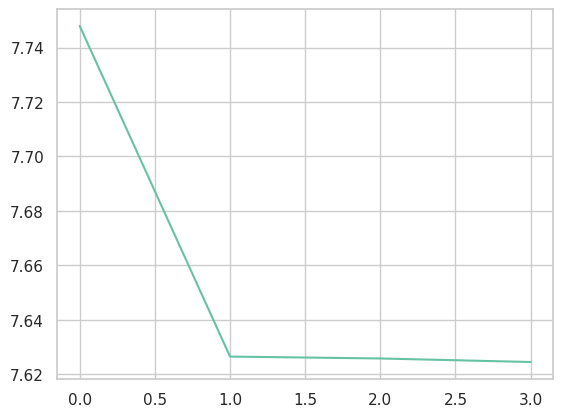

In [202]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [59]:
progress_bar = tqdm(range(EPOCHS))
start_time = time.time()

correct = 0
total = ns_test.size
print(total)
total = 0
correct = 0

NegativeSampling_dl_test = NegativeSampling_dl = DataLoader(NegativeSampleDadtaset(ns_test), shuffle = True,
                                 batch_size = 256, drop_last = True, pin_memory=True)
with torch.no_grad():
    for center, context, labels in NegativeSampling_dl_test:
        #print('center type = ', type(center), 'context type = ', type(context))
        #center, context = center.to(device).to(torch.float32), context.to(device).to(torch.float32)
        center, context = torch.tensor(center, dtype= int).to(device), torch.tensor(context, dtype=int).to(device)

        optimizer.zero_grad()
        logits = ns(center, context)

        loss = loss_fn(logits, labels.to(device))
        epoch_loss += loss.item()


        correct += ((logits > 0.5).to(device) == labels.to(device)).sum().item()
        total += logits.size()[0]
    progress_bar.update(1)
    epoch_loss /= len(dl)
    print(epoch_loss)

end_time = time.time()
print('Время обучения модели:', end_time - start_time)

print(total)
print(f'Accuracy:{correct/total}')

  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-59-fbdee46cfe3b>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center, context = torch.tensor(center, dtype= int).to(device), torch.tensor(context, dtype=int).to(device)
100%|██████████| 3/3 [01:00<00:00, 20.08s/it]


1801512


 33%|███▎      | 1/3 [00:18<00:36, 18.22s/it]

338.92290968854024
Время обучения модели: 18.220929861068726
600320
Accuracy:0.8793560101279317


In [194]:
progress_bar = tqdm(range(EPOCHS))
start_time = time.time()

correct = 0
total = ns_test.size
print(total)
total = 0
correct = 0
loss_fn = nn.CrossEntropyLoss()
dl_test = DataLoader(Word2VecDataset(test), shuffle = True,
                                 batch_size = 256, drop_last = True, pin_memory=True)

with torch.no_grad():
    for center, context in dl_test:
        #print('center type = ', type(center), 'context type = ', type(context))
        #center, context = center.to(device), context.to(device)
        center, context = torch.tensor(center, dtype=int).to(device), torch.tensor(context, dtype=int).to(device)

        optimizer.zero_grad()
        predicts = model(center)

        loss = loss_fn(predicts, context)
        epoch_loss += loss.item()
        predicts = torch.argsort(predicts, dim = 1)

        predicts = list(predicts.cpu().numpy())
        center = list(center.cpu().numpy())

        hit_arr = [1] * len(center)

        for i, (predict, central_word) in enumerate(zip(predicts, center)):
          set_context = contexts[central_word]
          if predict[0] not in set(set_context):
            hit_arr[i] = 0

        correct += sum(hit_arr)
        total += logits.size()[0]
    progress_bar.update(1)
    epoch_loss /= len(dl)
    print(epoch_loss)

end_time = time.time()
print('Время обучения модели:', end_time - start_time)

print(total)
print(f'Accuracy:{correct/total}')


  5%|▌         | 1/20 [00:51<16:13, 51.26s/it]
<ipython-input-194-9d7f38f3b1f6>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  center, context = torch.tensor(center, dtype=int).to(device), torch.tensor(context, dtype=int).to(device)


1801512



  5%|▌         | 1/20 [00:13<04:10, 13.19s/it]

146.9610305355967
Время обучения модели: 13.203563690185547
300032
Accuracy:0.0008065806313993174


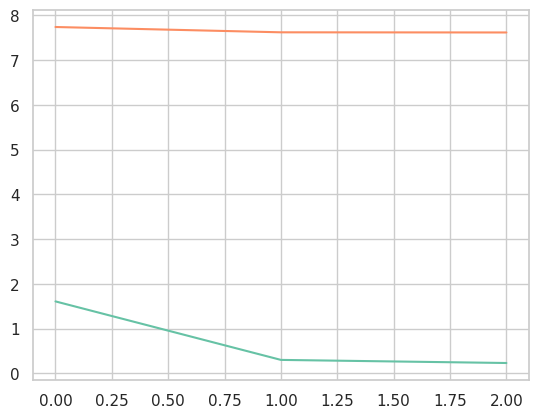

In [84]:
import matplotlib.pyplot as plt

plt.plot(running_loss_ns, label = 'negative sampling w2v')
plt.plot(running_loss, label = 'basic w2v')

In [62]:
params = model.state_dict()
Embedding_representation = params['embed.weight'].cpu().numpy()
Embedding_representation.shape

(3606, 128)

In [63]:
from scipy.spatial import distance
import numpy as np

def get_k_similar_words(word, dist_matrix, k=10):
    idx = word2id[word]
    print(dist_matrix.shape)
    print(idx)
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2word[i], dists[i]) for i in ind]
    return out

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

dist_matrix = get_distance_matrix(Embedding_representation, 'cosine')


for i, word in enumerate(words):
  print(word, [t[1] for t in get_k_similar_words(word, dist_matrix)], "\n")
  if (i > 10):
    break

(3606, 3606)
0
л ['спальн', 'город', 'низк', 'пожал', 'кузьмич', 'проспект', 'сказа', 'шаг', 'плеч', 'влаг'] 

(3606, 3606)
1
н ['жен', 'секретн', 'покаян', 'конференц', 'выказыва', 'пожертвова', 'несравнен', 'пол', 'составля', 'почувствова'] 

(3606, 3606)
2
достоевск ['счит', 'межсезон', 'знач', 'деятельн', 'глав', 'я', 'владычеств', 'укор', 'сынов', 'преселя'] 

(3606, 3606)
3
кампан ['приказыва', 'всяк', 'происшеств', 'конкретн', 'неужел', 'изолирова', 'психологическ', 'избавлен', 'древн', 'контролирова'] 

(3606, 3606)
4
континент ['погуб', 'функционир', 'изложен', 'способств', 'вполн', 'историографическ', 'останавлив', 'науч', 'эт', 'председател'] 

(3606, 3606)
5
имен ['предположен', 'разобра', 'смерт', 'высочеств', 'пыла', 'стыд', 'извол', 'выражен', 'неспешн', 'деликатн'] 

(3606, 3606)
6
преда ['надот', 'кажут', 'председател', 'подход', 'геройств', 'проступк', 'наряд', 'неясн', 'поверя', 'доказа'] 

(3606, 3606)
7
невольник ['назатыльник', 'царевич', 'призна', 'скрыт', 'нераз

In [40]:
word2id['наполеон']

987

In [64]:
stemmer = SnowballStemmer('russian')

def word2vec(word):
  word = stemmer.stem(word)
  id = word2id[word]
  return Embedding_representation[i, :].reshape(1, -1)

def iword2vec(vec):
    idx = word2id[word]
    print(dist_matrix.shape)
    print(idx)
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][0:]
    out = [(i, id2word[i], dists[i]) for i in ind]
    return out

def euclidean_norm(v):
  return distance.euclidean(v, np.zeros(len(v)))

def get_nearest(vec, metric_fn = euclidean_norm):
  '''print('vec', vec.shape)
  print('Embedding_representation shape:', Embedding_representation.shape)'''

  arr = Embedding_representation - vec
  #print(arr[1952, :].reshape(-1, 1))
  dist = np.apply_along_axis(metric_fn, axis = 1,
                            arr = arr)
  id = np.argsort(dist)
  return id

In [65]:
dist_matrix = get_distance_matrix(Embedding_representation, 'cosine')

In [83]:
ns_params = ns.state_dict()
Embedding_representation_ns = ns_params['embed.weight'].cpu().numpy()

dist_matrix_ns = get_distance_matrix(Embedding_representation_ns, 'cosine')
delta = Embedding_representation_ns - Embedding_representation
np.linalg.norm(delta, 'fro')

389.7429

In [81]:
get_k_similar_words('люб', dist_matrix_ns, k = 20)

(3606, 3606)
2544


[(2234, 'шепч', 0.6565570992252798),
 (439, 'незнаком', 0.7267014811318335),
 (3384, 'бородк', 0.7356276280210872),
 (3405, 'функционир', 0.7462394485242351),
 (428, 'крошечн', 0.7561442958185229),
 (1701, 'скрыва', 0.757143059031493),
 (1649, 'пылк', 0.7575273455712536),
 (3057, 'крик', 0.7584107790557153),
 (1520, 'ужина', 0.7613826602528287),
 (561, 'мужчин', 0.7641165588250654),
 (192, 'увидет', 0.7647477593312597),
 (1686, 'польз', 0.7665097222626212),
 (3537, 'тракт', 0.7676431432902353),
 (2810, 'куд', 0.7688600027276253),
 (2298, 'сипл', 0.7713177818162588),
 (1879, 'предугадыва', 0.7721246517513515),
 (3107, 'затухан', 0.7722105336677025),
 (1965, 'невидим', 0.772534386682038),
 (1112, 'невестк', 0.7740243586800273),
 (2996, 'передник', 0.7767271334453855)]

In [45]:
get_k_similar_words(word, dist_matrix_ns, k = 4)

(3606, 3606)
10


[(2292, 'задрожа', 0.7054918945872617),
 (1607, 'рным', 0.7064741673888624),
 (2294, 'умилительн', 0.7092665558788421),
 (1902, 'помн', 0.7130071986369235)]

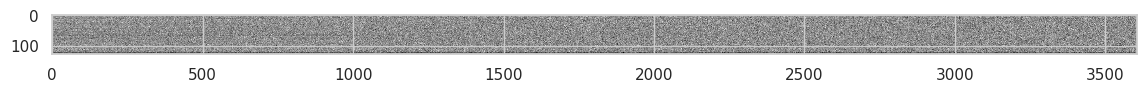

In [71]:
# Выведем матрицу расстояний между словами
plt.figure(figsize = (14, 14))
plt.imshow(delta.T, cmap = 'gray', interpolation='none', norm =  matplotlib.colors.Normalize())
plt.show()